# Classification Audio Chien/Chat avec CNN

Dans ce notebook, nous allons réaliser une classification audio binaire pour distinguer les sons de chiens et de chats. Pour cela, nous utiliserons un réseau de neurones convolutif (CNN). Cette approche nous permettra de capturer les caractéristiques temporelles et fréquentielles des sons pour effectuer une classification précise.

## 1. Installation et importation des bibliothèques nécessaires

In [24]:
# Installation des bibliothèques (à exécuter si nécessaire)
# !pip install librosa numpy matplotlib scikit-learn pandas tensorflow

In [25]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import seaborn as sns
import tensorflow as tf
from IPython.display import Audio
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
from PIL import Image

# Pour être sûr que les graphiques s'affichent dans le notebook
%matplotlib inline

## 2. Analysons un fichier audio

In [26]:
audio_file = 'data/cat_2.wav'

In [27]:
# Écoute du son
Audio(audio_file)

In [28]:
# Chargement du fichier audio avec librosa
y, sr = librosa.load(audio_file)

# Affichage des informations sur l'échantillonnage
print(f"Taux d'échantillonnage (sr): {sr} Hz")
print(f"Durée du signal: {len(y)/sr:.2f} secondes")

Taux d'échantillonnage (sr): 22050 Hz
Durée du signal: 12.00 secondes


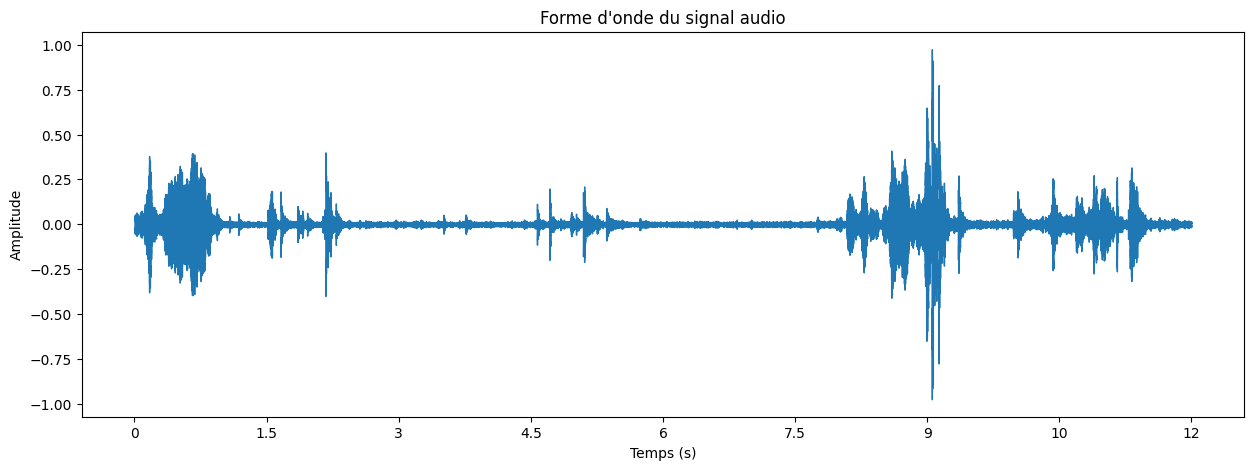

In [29]:

# Affichage de la forme d'onde avec librosa
plt.figure(figsize=(15, 5))
librosa.display.waveshow(y, sr=sr)
plt.title("Forme d'onde du signal audio")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.show()



### Interprétation du signal audio :
Le signal présente une forme d'onde caractéristique d'un miaulement de chat, avec des variations d'amplitude modérées et une structure temporelle bien définie. Les pics d'amplitude correspondent aux moments d'émission sonore, tandis que les creux représentent les silences entre les vocalisations.


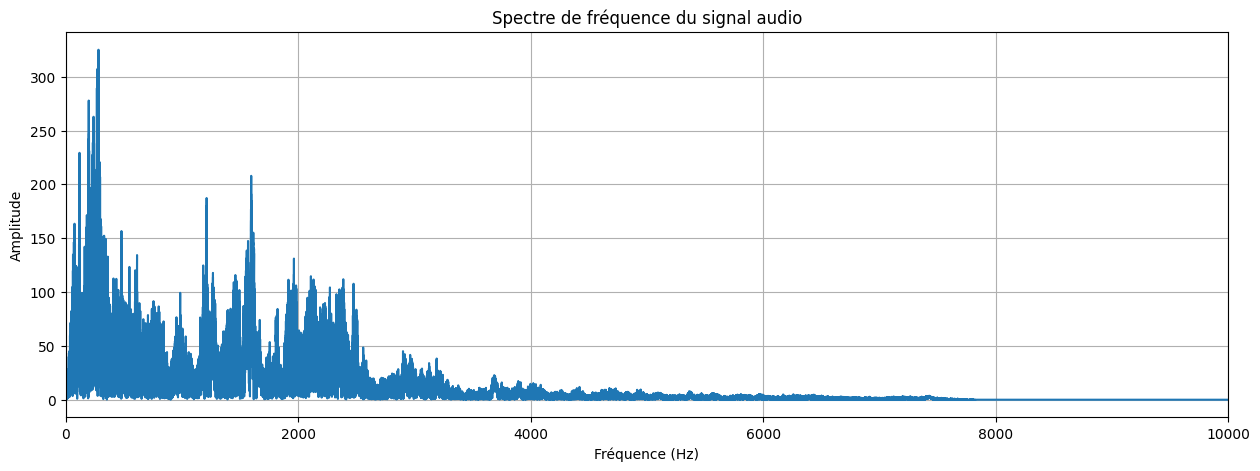

In [30]:
# Affichage du spectre de fréquence
plt.figure(figsize=(15, 5))
# Calcul des fréquences correspondantes à la FFT
freqs = np.fft.rfftfreq(len(y), 1/sr)
plt.plot(freqs, np.abs(np.fft.rfft(y)))
plt.title("Spectre de fréquence du signal audio")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 10000)  # Limite l'affichage aux fréquences jusqu'à 10kHz pour plus de clarté
plt.grid(True)
plt.show()


### Interprétation du spectre de fréquence :
Le spectre montre une concentration d'énergie dans les basses fréquences (0-2000 Hz), typique des vocalisations félines. 


## 2. Découpons ce son en frames

Nombre de frames: 961
Longueur de chaque frame: 551 échantillons
Durée de chaque frame: 0.025 secondes


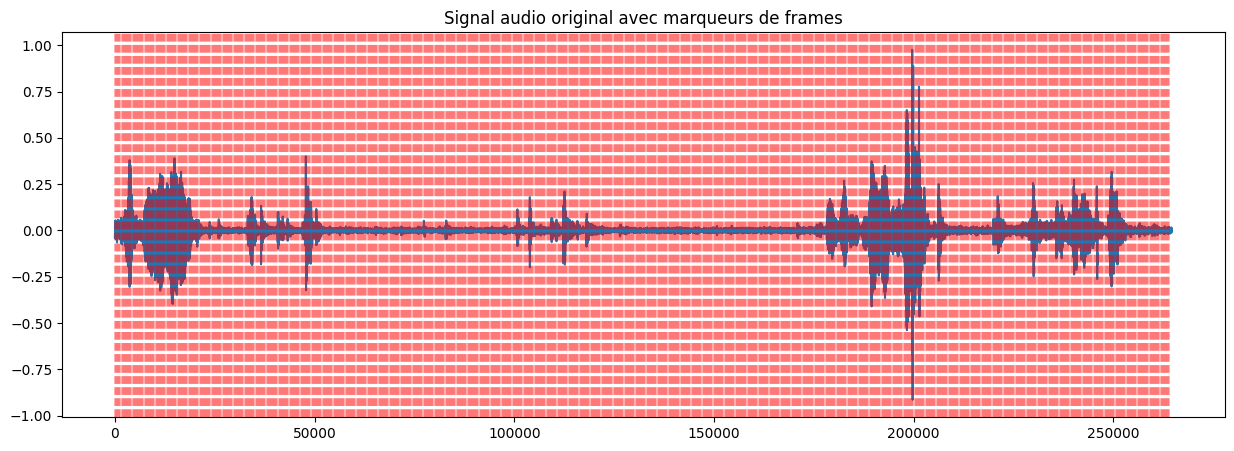

In [31]:
# Définition des paramètres pour le découpage
frame_length = int(sr / 40)  # 1 seconde divisée en 40 frames
hop_length = frame_length // 2  # Chevauchenment de 50%

# Découpage du signal en frames
frames = librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)

# Affichage des informations sur les frames
print(f"Nombre de frames: {frames.shape[1]}")
print(f"Longueur de chaque frame: {frames.shape[0]} échantillons")
print(f"Durée de chaque frame: {frame_length/sr:.3f} secondes")

# Visualisation des frames
plt.figure(figsize=(15, 5))
plt.plot(y)
plt.title("Signal audio original avec marqueurs de frames")
for i in range(frames.shape[1]):
    plt.axvline(x=i * hop_length, color='r', linestyle='--', alpha=0.3)
plt.show()


## Visualisation des 5 premières frames du signal audio

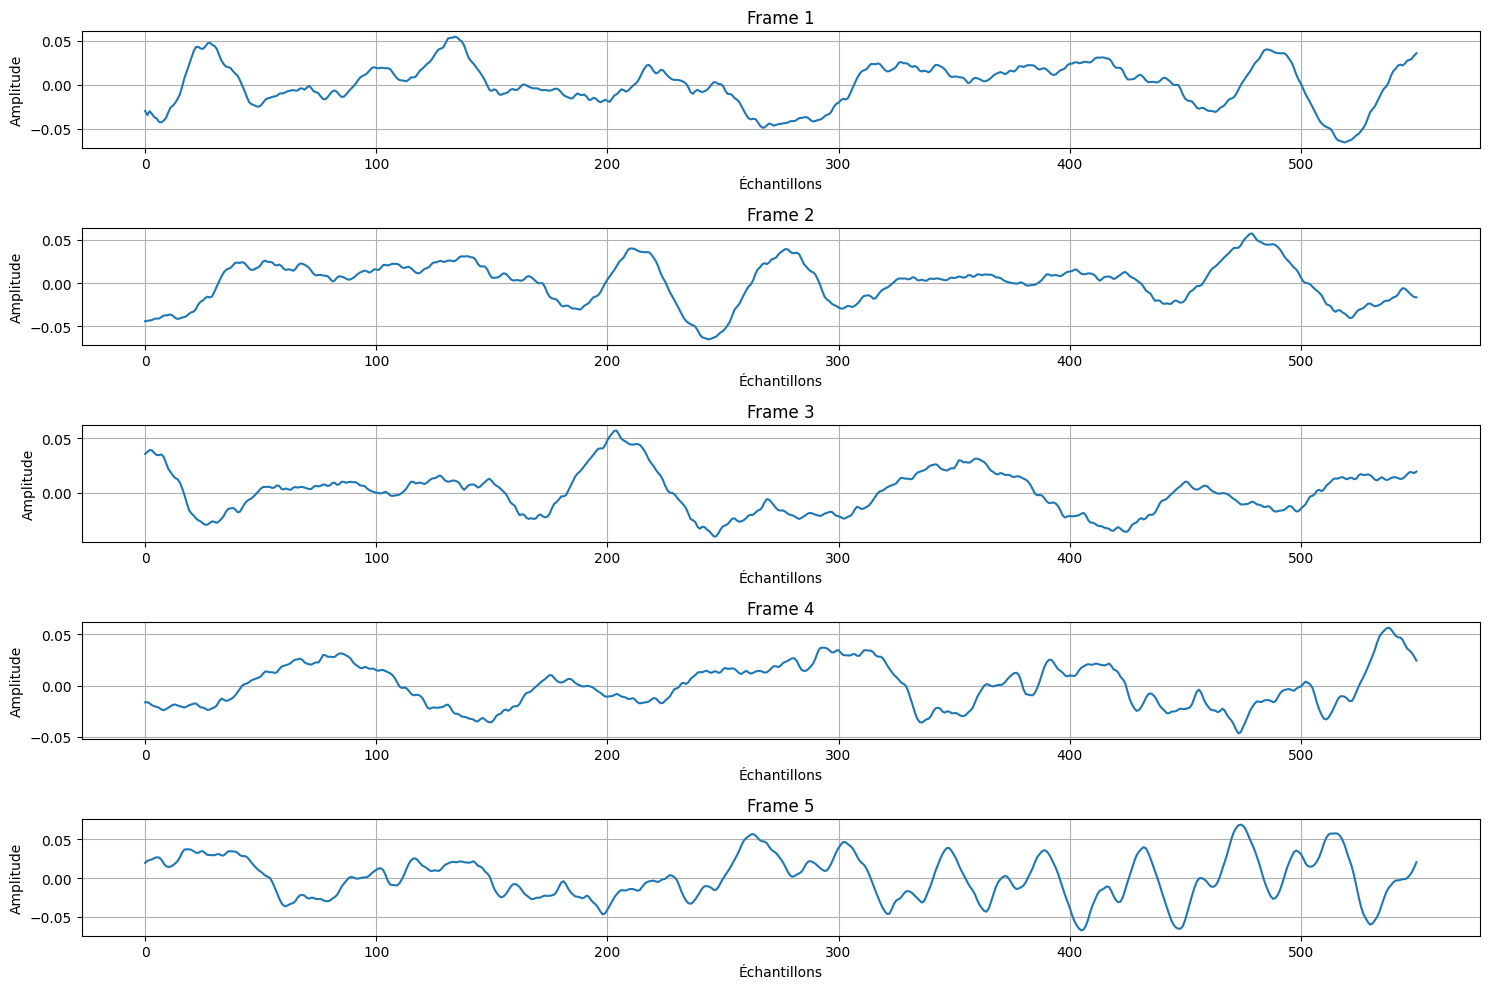

In [32]:

plt.figure(figsize=(15, 10))  # Création d'une figure de taille 15x10 pouces

# Pour chaque frame (de 0 à 4)
for i in range(5):
    plt.subplot(5, 1, i+1)  # Création de 5 sous-graphiques empilés verticalement
    plt.plot(frames[:, i])  # Tracé de la frame i
    plt.title(f"Frame {i+1}")  # Titre indiquant le numéro de la frame
    plt.xlabel("Échantillons")  # L'axe x représente les échantillons audio dans le temps
    plt.ylabel("Amplitude")    # L'axe y représente l'amplitude du signal
    plt.grid(True)            # Ajout d'une grille pour faciliter la lecture

plt.tight_layout()  # Ajuste automatiquement l'espacement entre les sous-graphiques
plt.show()

# Explication des axes :
# - Axe X (Échantillons) : représente le temps discret, chaque point est un échantillon audio
# - Axe Y (Amplitude) : représente l'intensité du son à chaque instant


## Analyse des spectres de fréquence de ces frames

Chaque frame présente un spectre de fréquence différent, ce qui est normal car le signal audio évolue dans le temps. Les pics d'amplitude à différentes fréquences représentent les composantes sonores dominantes à chaque instant. La distribution de l'énergie entre les basses et hautes fréquences varie d'une frame à l'autre reflétant ainsi la nature dynamique du signal audio original.


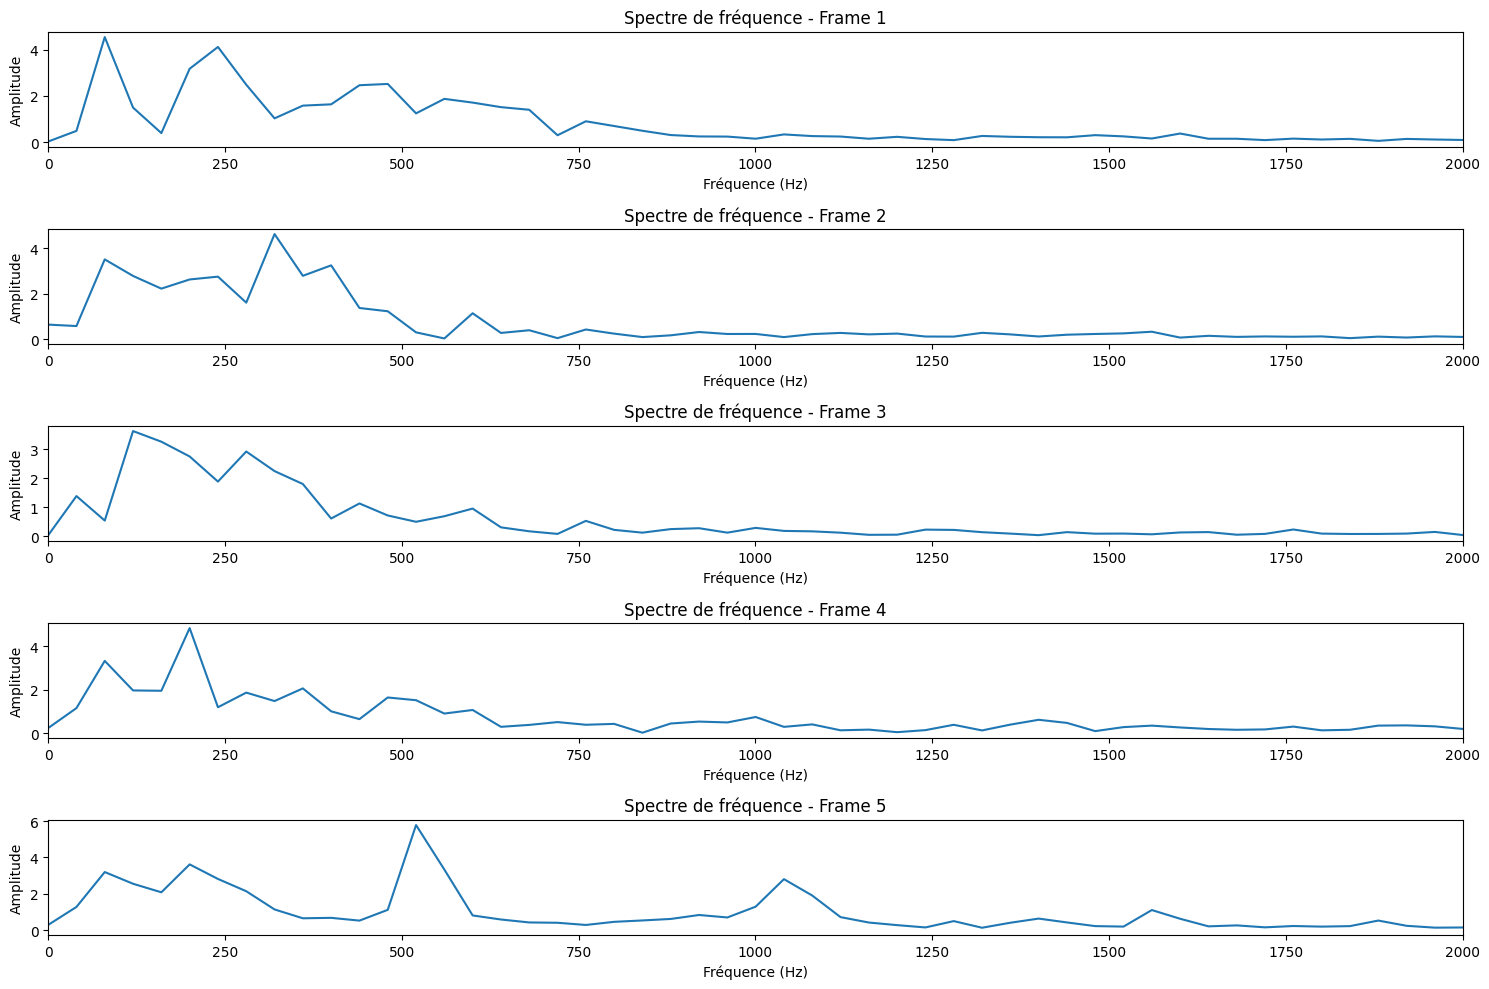

Nombre de fréquences analysées: 276
Freq min: 0.0 Hz
Freq max: 11005.0 Hz
Résolution fréquentielle: 40.0 Hz


In [33]:
# Calcul de la FFT pour chaque frame
fft_frames = np.fft.rfft(frames, axis=0)

# Calcul de la magnitude (amplitude) des fréquences
magnitude_frames = np.abs(fft_frames)

# Calcul des fréquences correspondantes
freqs = np.fft.rfftfreq(frame_length, d=1/sr)

# Affichage des spectres de fréquence pour les 5 premières frames
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(freqs, magnitude_frames[:, i])
    plt.title(f"Spectre de fréquence - Frame {i+1}")
    plt.xlabel("Fréquence (Hz)")
    plt.ylabel("Amplitude")
    plt.xlim(0, 2000)  # Limite l'affichage aux fréquences jusqu'à 2000 Hz
plt.tight_layout()
plt.show()

# Affichage des informations sur la FFT
print(f"Nombre de fréquences analysées: {len(freqs)}")
print(f"Freq min: {freqs[0]:.1f} Hz")
print(f"Freq max: {freqs[-1]:.1f} Hz")
print(f"Résolution fréquentielle: {freqs[1]-freqs[0]:.1f} Hz")


### Le graphique ci-dessus montre les spectres de fréquence pour les 5 premières frames du signal audio.
Pour chaque frame, on peut observer la distribution de l'énergie sonore en fonction de la fréquence. Comme le montre le spectre de fréquence du signal, on voit beaucoup plus d'amplitude dans les fréquences basses.


## L'échelle de Mel

In [34]:
n_mels = 40  # Nombre de filtres Mel
mel_basis = librosa.filters.mel(sr=sr, n_fft=frame_length, n_mels=n_mels)

# Application du filtre Mel aux spectres de magnitude
mel_spectrogram = np.dot(mel_basis, magnitude_frames)

### La gueule du filtre de Mel

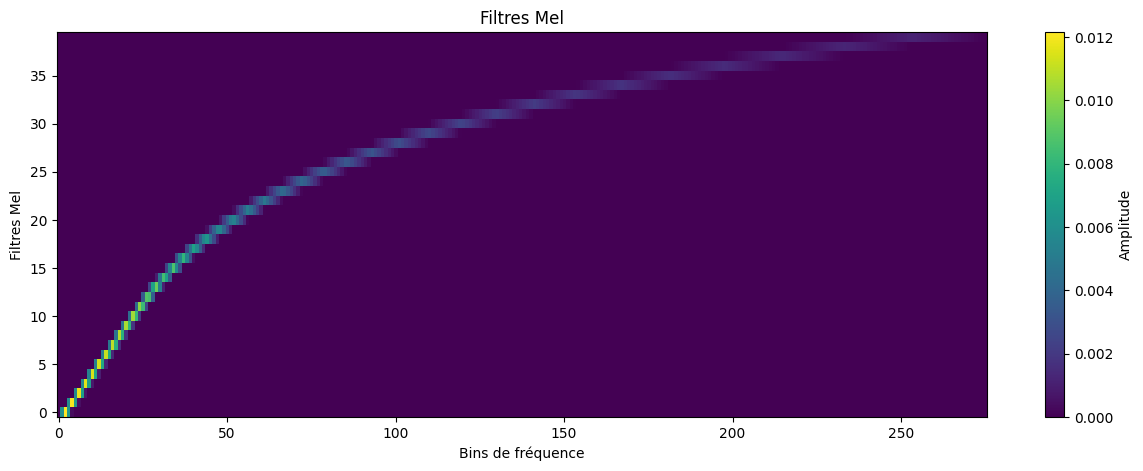

In [35]:

# Affichage des filtres Mel
plt.figure(figsize=(15, 5))
plt.imshow(mel_basis, aspect='auto', origin='lower')
plt.title("Filtres Mel")
plt.xlabel("Bins de fréquence")
plt.ylabel("Filtres Mel")
plt.colorbar(label="Amplitude")
plt.show()


### Explication

Ce premier graphique montre les "filtres Mel", qui sont comme des lunettes spéciales qui nous permettent de voir les sons comme notre oreille les perçoit. 

En effet, notre oreille n'entend pas toutes les fréquences de la même manière :
- Nous sommes plus sensibles aux sons moyens (comme la voix humaine)
- Nous entendons moins bien les sons très graves ou très aigus

Les filtres Mel (représentés par les lignes horizontales colorées) transforment 
les fréquences "physiques" en fréquences "perçues" par l'oreille humaine.

## Le mel spectrogramme

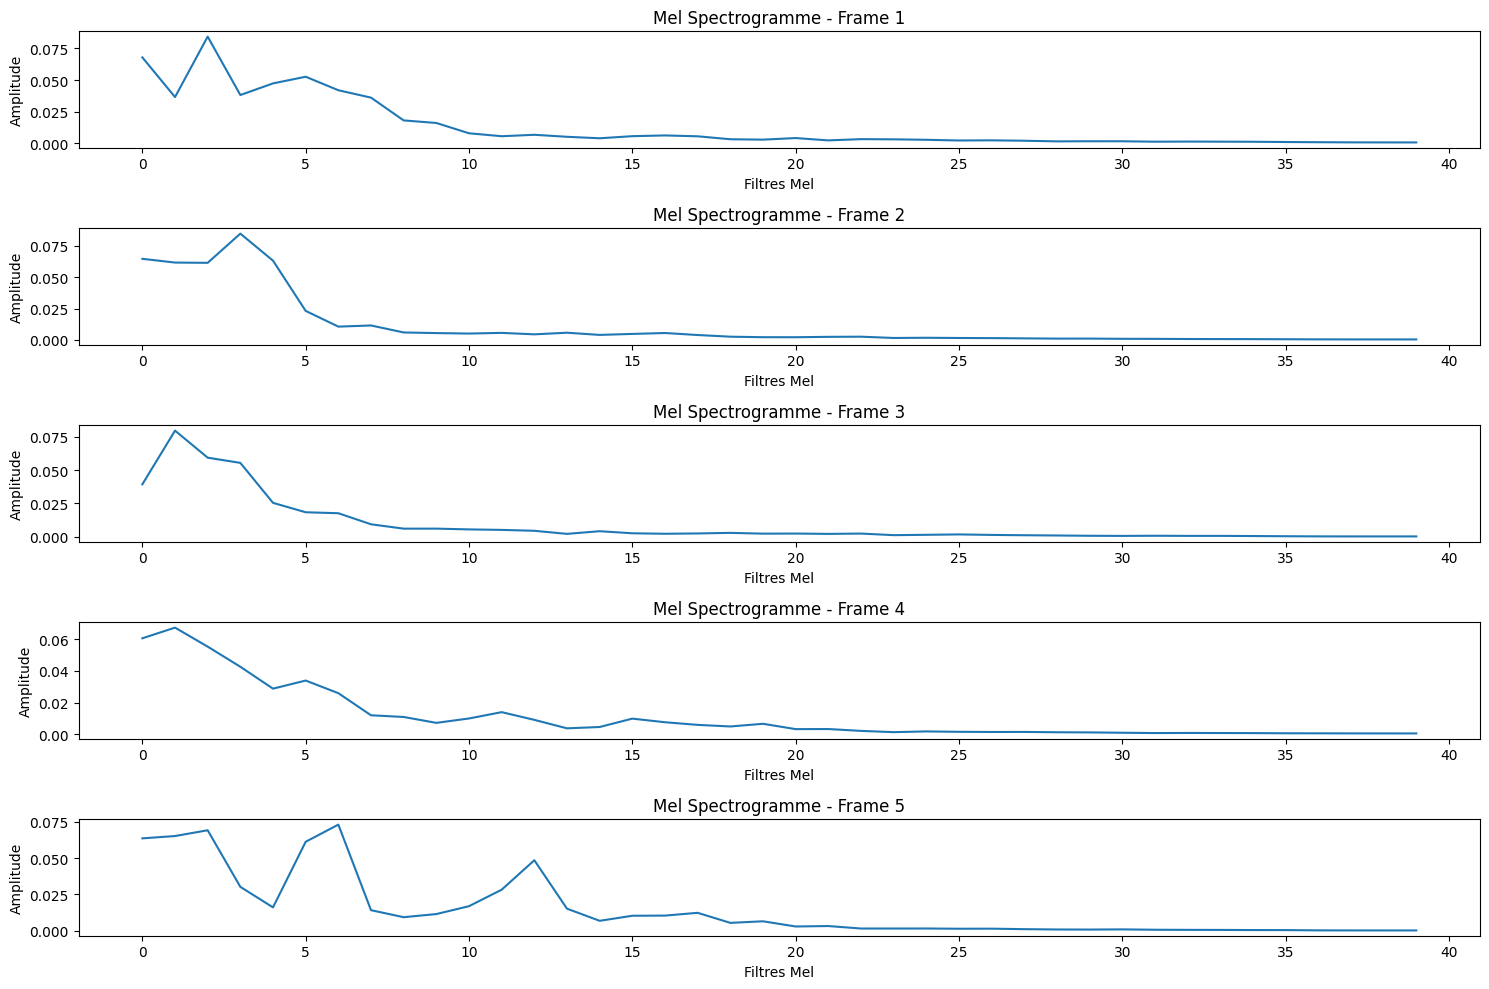

Nombre de filtres Mel: 40
Dimensions du mel spectrogramme: (40, 961)


In [36]:

# Affichage du mel spectrogramme pour les 5 premières frames
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(mel_spectrogram[:, i])
    plt.title(f"Mel Spectrogramme - Frame {i+1}")
    plt.xlabel("Filtres Mel")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Affichage des informations sur le mel spectrogramme
print(f"Nombre de filtres Mel: {n_mels}")
print(f"Dimensions du mel spectrogramme: {mel_spectrogram.shape}")



### Explication du Mel Spectrogramme

Ce graphique montre 5 "images" du son, appelées "frames". Chaque image représente comment le son est perçu à un moment précis par l'oreille humaine.

Sur chaque graphique :
- L'axe horizontal (x) montre les différents filtres Mel (de 0 à 40)
- L'axe vertical (y) montre l'intensité du son (l'amplitude)
- Plus la courbe est haute, plus le son est fort à cette fréquence

C'est comme si nous avions pris 5 photos du son à des moments différents, et que chaque photo nous montrait comment le son est perçu par notre oreille à ce moment précis.

Ces représentations sont très utiles pour l'analyse automatique des sons, car elles reflètent mieux la façon dont nous percevons les sons que les représentations techniques traditionnelles.


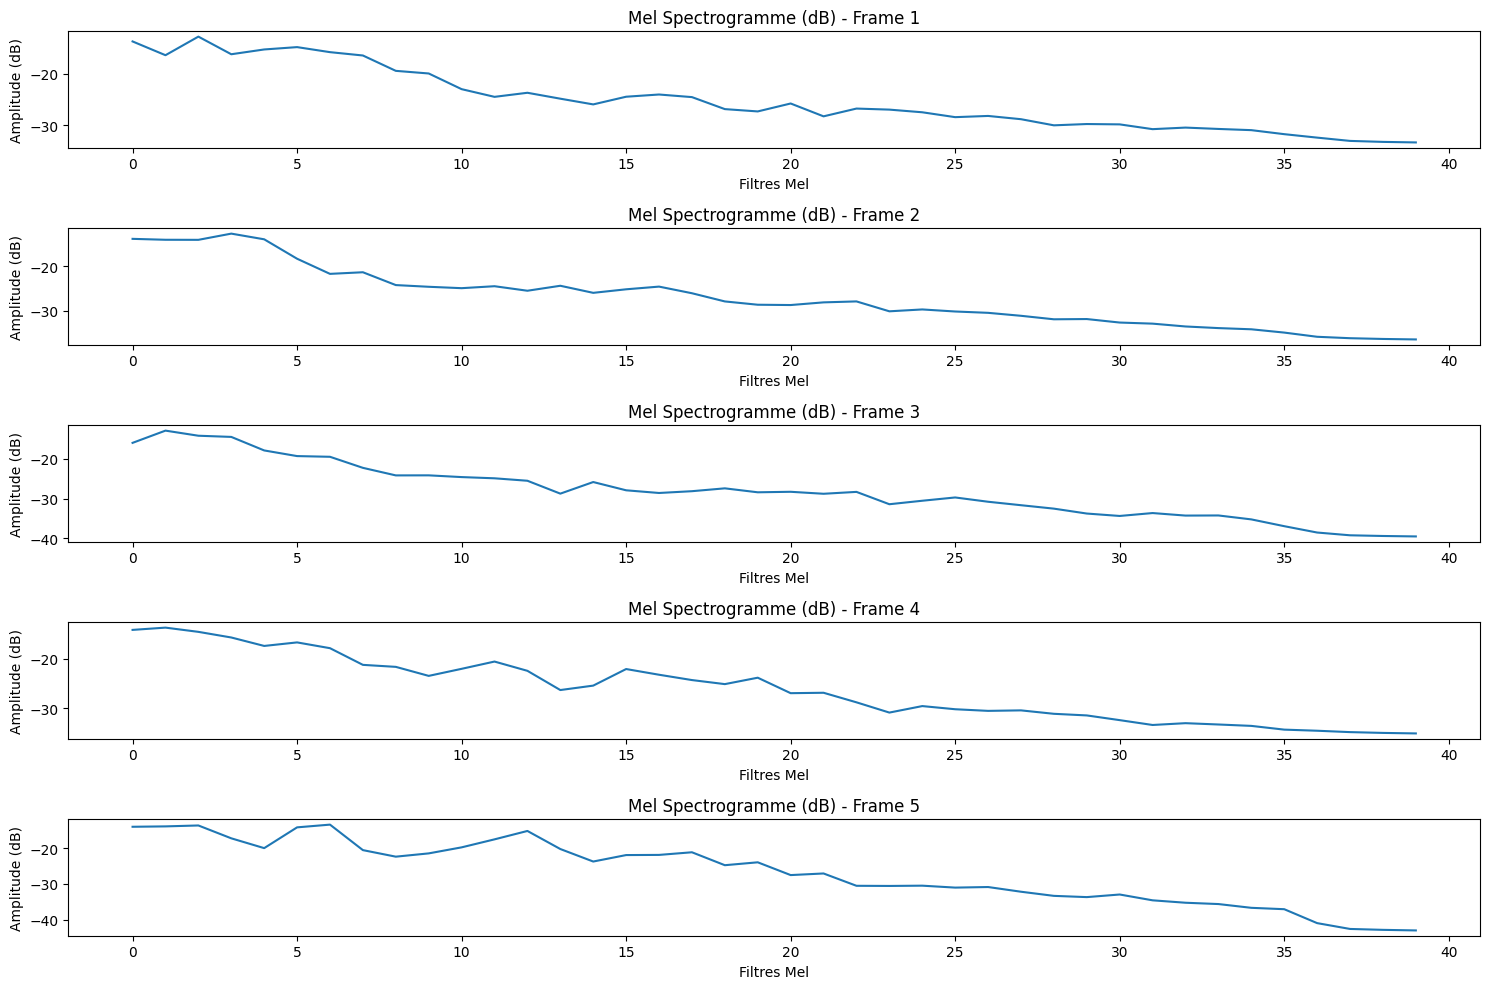

Dimensions du mel spectrogramme en dB: (40, 961)
Valeurs min/max en dB: -62.39 / 0.00 dB


In [37]:
# Conversion du mel spectrogramme en dB (décibels)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Affichage du mel spectrogramme en dB pour les 5 premières frames
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(mel_spectrogram_db[:, i])
    plt.title(f"Mel Spectrogramme (dB) - Frame {i+1}")
    plt.xlabel("Filtres Mel")
    plt.ylabel("Amplitude (dB)")
plt.tight_layout()
plt.show()

# Affichage des informations sur le mel spectrogramme en dB
print(f"Dimensions du mel spectrogramme en dB: {mel_spectrogram_db.shape}")
print(f"Valeurs min/max en dB: {mel_spectrogram_db.min():.2f} / {mel_spectrogram_db.max():.2f} dB")

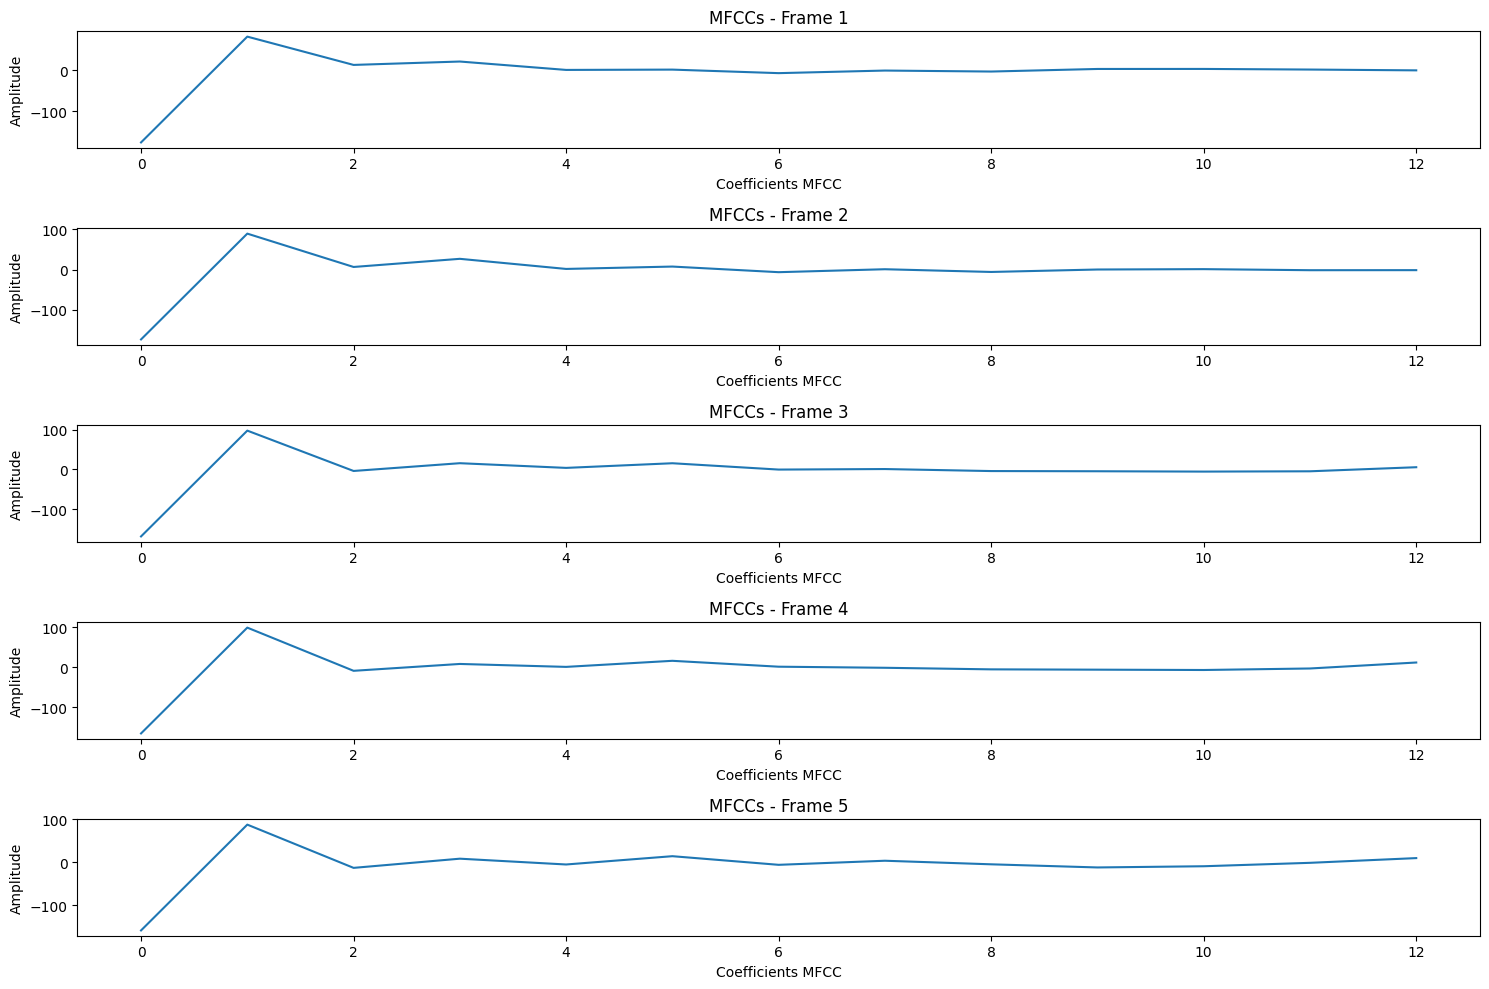

Nombre de coefficients MFCC: 13
Dimensions des MFCCs: (13, 5)
Valeurs min/max des MFCCs: -175.39 / 99.36


In [38]:
# Application de la DCT (Discrete Cosine Transform) pour obtenir les MFCCs
n_mfcc = 13  # Nombre de coefficients MFCC à extraire

# Chargement du fichier audio en tant que tableau numpy
y, sample_rate = librosa.load(audio_file)

# Calcul des MFCCs pour les 5 premières frames
mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=n_mfcc, n_mels=n_mels)[:, :5]

# Affichage des MFCCs pour les 5 premières frames
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(5, 1, i+1)
    plt.plot(mfccs[:, i])
    plt.title(f"MFCCs - Frame {i+1}")
    plt.xlabel("Coefficients MFCC")
    plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Affichage des informations sur les MFCCs
print(f"Nombre de coefficients MFCC: {n_mfcc}")
print(f"Dimensions des MFCCs: {mfccs.shape}")
print(f"Valeurs min/max des MFCCs: {mfccs.min():.2f} / {mfccs.max():.2f}")


## MFCCs (Mel-Frequency Cepstral Coefficients)
Les MFCCs sont une représentation plus compacte du son qui capture ses caractéristiques principales :
- Le premier coefficient (en bas) représente l'énergie globale du son
- Les coefficients suivants capturent des aspects plus détaillés comme la répartition des fréquences
- Cette représentation est particulièrement utile pour la reconnaissance vocale car elle met en évidence les caractéristiques distinctives de la voix

Ces deux visualisations nous aident à comprendre comment un son peut être représenté numériquement pour l'analyse par des algorithmes d'apprentissage automatique.


In [39]:
# Affichage des valeurs numériques des MFCCs pour les 5 premières frames
print("\nValeurs numériques des MFCCs pour les 5 premières frames :")
for i in range(5):
    print(f"\nFrame {i+1}:")
    for j in range(n_mfcc):
        print(f"MFCC {j+1}: {mfccs[j, i]:.4f}")



Valeurs numériques des MFCCs pour les 5 premières frames :

Frame 1:
MFCC 1: -175.3879
MFCC 2: 81.0688
MFCC 3: 12.4858
MFCC 4: 20.7066
MFCC 5: 0.3695
MFCC 6: 1.1248
MFCC 7: -7.4464
MFCC 8: -1.1664
MFCC 9: -3.5572
MFCC 10: 2.6815
MFCC 11: 2.7610
MFCC 12: 1.2549
MFCC 13: -0.7028

Frame 2:
MFCC 1: -173.5463
MFCC 2: 89.6752
MFCC 3: 6.7168
MFCC 4: 26.9774
MFCC 5: 1.8315
MFCC 6: 7.7298
MFCC 7: -6.2468
MFCC 8: 1.0832
MFCC 9: -5.6873
MFCC 10: 0.3979
MFCC 11: 1.3156
MFCC 12: -1.3301
MFCC 13: -1.1839

Frame 3:
MFCC 1: -168.2129
MFCC 2: 97.2505
MFCC 3: -3.9891
MFCC 4: 15.5141
MFCC 5: 3.7539
MFCC 6: 15.3999
MFCC 7: -0.4718
MFCC 8: 0.8530
MFCC 9: -4.2070
MFCC 10: -4.6851
MFCC 11: -5.5433
MFCC 12: -4.7854
MFCC 13: 5.4270

Frame 4:
MFCC 1: -166.2374
MFCC 2: 99.3616
MFCC 3: -9.0423
MFCC 4: 8.1691
MFCC 5: 0.8153
MFCC 6: 16.0458
MFCC 7: 1.2803
MFCC 8: -1.4310
MFCC 9: -5.4025
MFCC 10: -6.1848
MFCC 11: -7.0048
MFCC 12: -3.2015
MFCC 13: 11.7917

Frame 5:
MFCC 1: -159.0535
MFCC 2: 87.9625
MFCC 3: -12.9920


## Intéressons-nous à l'entraînement de notre modèle

In [40]:
### Dans un premier temps, regardons les durées de nos sons dans notre dataset audio

🔎 Nombre de fichiers analysés : 210
⏱️ Durée moyenne : 7.20 s
📏 Médiane : 6.71 s
📉 Min : 0.94 s
📈 Max : 17.69 s
📊 >2s : 179 fichiers
📊 <1s : 4 fichiers


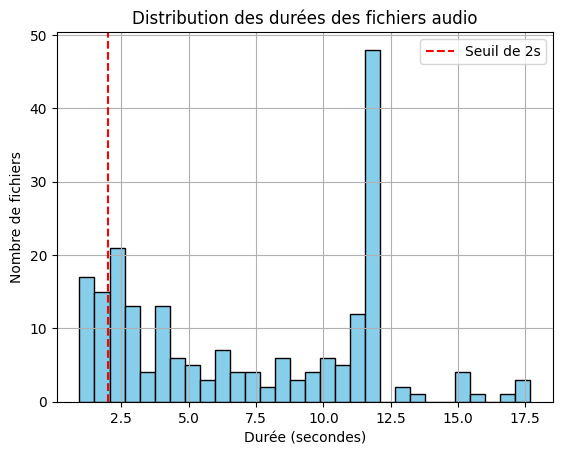

In [41]:
# === PARAMÈTRES ===
DATA_DIR = 'data/train'  # ou 'data/test'
CLASSES = ['cats', 'dogs']
SR = 22050  # taux d'échantillonnage

# === COLLECTE DES DURÉES ===
durations = []

for classe in CLASSES:
    path_classe = os.path.join(DATA_DIR, classe)
    if not os.path.exists(path_classe):
        continue

    for fichier in os.listdir(path_classe):
        if fichier.endswith('.wav'):
            try:
                chemin = os.path.join(path_classe, fichier)
                y, sr = librosa.load(chemin, sr=SR)
                duration = librosa.get_duration(y=y, sr=sr)
                durations.append(duration)
            except Exception as e:
                print(f"Erreur sur {fichier} : {e}")

# === STATS ===
import numpy as np
durations = np.array(durations)

print(f"🔎 Nombre de fichiers analysés : {len(durations)}")
print(f"⏱️ Durée moyenne : {durations.mean():.2f} s")
print(f"📏 Médiane : {np.median(durations):.2f} s")
print(f"📉 Min : {durations.min():.2f} s")
print(f"📈 Max : {durations.max():.2f} s")
print(f"📊 >2s : {(durations > 2).sum()} fichiers")
print(f"📊 <1s : {(durations < 1).sum()} fichiers")

# === HISTOGRAMME DES DURÉES ===
plt.hist(durations, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution des durées des fichiers audio")
plt.xlabel("Durée (secondes)")
plt.ylabel("Nombre de fichiers")
plt.axvline(2.0, color='red', linestyle='--', label='Seuil de 2s')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

# === PARAMÈTRES ===
DURATION = 7.0
SR = 22050
OUTPUT_SIZE = 154  # nombre de trames temporelles
N_MFCC = 13
CLASSES = ['cats', 'dogs']
IMG_HEIGHT = 19  # 13 MFCC + 6 descripteurs
IMG_WIDTH = OUTPUT_SIZE

def extraire_mfcc(y, sr, hop_length):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC, hop_length=hop_length)
    mfcc = mfcc[:, :OUTPUT_SIZE]  # (13, 44)
    if mfcc.shape[1] < OUTPUT_SIZE:
        pad = OUTPUT_SIZE - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad)), mode='constant')
    return mfcc

def extraire_descripteurs(y, sr, hop_length):
    def ajuster(x):
        x = x[:OUTPUT_SIZE]
        if len(x) < OUTPUT_SIZE:
            return np.pad(x, (0, OUTPUT_SIZE - len(x)), mode='constant')
        return x

    rms = ajuster(librosa.feature.rms(y=y, hop_length=hop_length)[0])
    zcr = ajuster(librosa.feature.zero_crossing_rate(y, hop_length=hop_length)[0])
    centroid = ajuster(librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length)[0])
    bandwidth = ajuster(librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=hop_length)[0])
    flatness = ajuster(librosa.feature.spectral_flatness(y=y, hop_length=hop_length)[0])
    rolloff = ajuster(librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=hop_length)[0])

    descs = np.stack([rms, zcr, centroid, bandwidth, flatness, rolloff], axis=0)  # (6, 44)

    # Normalisation ligne par ligne
    descs = (descs - descs.min(axis=1, keepdims=True)) / \
            (descs.max(axis=1, keepdims=True) - descs.min(axis=1, keepdims=True) + 1e-9)
    return descs

# def genere_image_mfcc_descripteurs(audio_path, output_path):
#     try:
#         y, sr = librosa.load(audio_path, sr=SR, duration=DURATION)
#         hop_length = int(len(y) / OUTPUT_SIZE)

#         mfcc = extraire_mfcc(y, sr, hop_length)  # (13, OUTPUT_SIZE)
#         descripteurs = extraire_descripteurs(y, sr, hop_length)  # (6, OUTPUT_SIZE)

#         image_data = np.vstack((mfcc, descripteurs))  # shape: (19, OUTPUT_SIZE)

#         # Normalisation [0, 255] pour image uint8
#         image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min() + 1e-9)
#         image_data = (image_data * 255).astype(np.uint8)

#         # Conversion et sauvegarde
#         img = Image.fromarray(image_data, mode='L')  # 'L' = grayscale
#         img.save(output_path)

#     except Exception as e:
#         print(f"Erreur avec {audio_path} : {e}")

#     except Exception as e:
#         print(f"Erreur avec {audio_path} : {e}")


In [43]:
# def traiter_repertoire_audio(input_dir, output_dir):
#     os.makedirs(output_dir, exist_ok=True)
#     for classe in CLASSES:
#         input_classe = os.path.join(input_dir, classe)
#         output_classe = os.path.join(output_dir, classe)
#         os.makedirs(output_classe, exist_ok=True)

#         if not os.path.exists(input_classe):
#             print(f"Répertoire inexistant : {input_classe}")
#             continue

#         for fichier in os.listdir(input_classe):
#             if fichier.endswith('.wav'):
#                 chemin_audio = os.path.join(input_classe, fichier)
#                 chemin_image = os.path.join(output_classe, fichier.replace('.wav', '.png'))
#                 genere_image_mfcc_descripteurs(chemin_audio, chemin_image)

# # Appel :
# traiter_repertoire_audio('data/train', 'fusion_images/train')
# traiter_repertoire_audio('data/test', 'fusion_images/test')
# print("✅ Fusion MFCC + descripteurs terminée.")


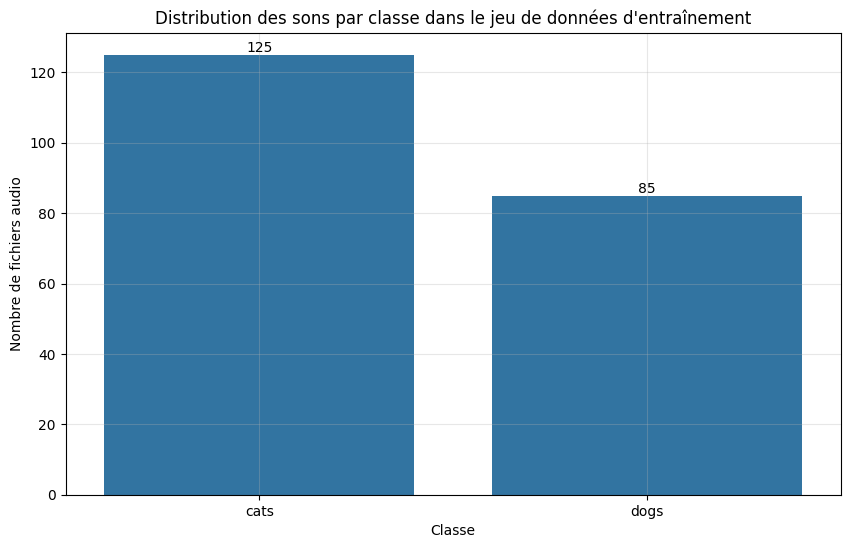


Statistiques de distribution :
cats: 125 fichiers
dogs: 85 fichiers


In [55]:
# Affichage de la distribution des sons par classe
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Comptage des fichiers par classe
train_dir = 'data/train'
classes = ['cats', 'dogs']
comptage = {}

for classe in classes:
    chemin_classe = os.path.join(train_dir, classe)
    if os.path.exists(chemin_classe):
        nb_fichiers = len([f for f in os.listdir(chemin_classe) if f.endswith('.wav')])
        comptage[classe] = nb_fichiers

# Création du graphique
plt.figure(figsize=(10, 6))
sns.barplot(x=list(comptage.keys()), y=list(comptage.values()))
plt.title('Distribution des sons par classe dans le jeu de données d\'entraînement')
plt.xlabel('Classe')
plt.ylabel('Nombre de fichiers audio')
plt.grid(True, alpha=0.3)

# Ajout des valeurs au-dessus des barres
for i, v in enumerate(comptage.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

# Affichage des statistiques
print("\nStatistiques de distribution :")
for classe, nb in comptage.items():
    print(f"{classe}: {nb} fichiers")


In [44]:
def extraire_moyennes_mfcc_descripteurs(audio_path, hop_length=512):
    """
    Extrait les moyennes des MFCC et descripteurs pour un fichier audio.
    
    Args:
        audio_path (str): Chemin vers le fichier audio
        hop_length (int): Longueur du hop pour l'analyse
        
    Returns:
        tuple: (moyennes_mfcc, moyennes_descripteurs)
            - moyennes_mfcc: array de shape (13,) contenant les moyennes des MFCC
            - moyennes_descripteurs: array de shape (6,) contenant les moyennes des descripteurs
    """
    try:
        # Chargement et prétraitement du signal
        y, sr = librosa.load(audio_path, sr=None)
        y = librosa.util.normalize(y)
        
        # Extraction des MFCC et descripteurs
        mfcc = extraire_mfcc(y, sr, hop_length)  # shape: (13, 154)
        descripteurs = extraire_descripteurs(y, sr, hop_length)  # shape: (6, 154)
        
        # Calcul des moyennes sur l'axe temporel (axis=1)
        moyennes_mfcc = np.mean(mfcc, axis=1)  # shape: (13,)
        moyennes_descripteurs = np.mean(descripteurs, axis=1)  # shape: (6,)
        
        return moyennes_mfcc, moyennes_descripteurs
        
    except Exception as e:
        print(f"Erreur lors du traitement de {audio_path}: {e}")
        return None, None

def traiter_repertoire_moyennes(input_dir, output_file):
    """
    Traite tous les fichiers audio d'un répertoire et sauvegarde les moyennes dans un fichier CSV.
    
    Args:
        input_dir (str): Répertoire contenant les sous-dossiers de classes
        output_file (str): Chemin du fichier CSV de sortie
    """
    # Préparation des colonnes pour le DataFrame
    colonnes = (['classe'] + 
               [f'mfcc_{i}' for i in range(13)] + 
               [f'desc_{i}' for i in range(6)])
    
    donnees = []
    
    for classe in CLASSES:
        input_classe = os.path.join(input_dir, classe)
        
        if not os.path.exists(input_classe):
            print(f"Répertoire inexistant : {input_classe}")
            continue
            
        for fichier in os.listdir(input_classe):
            if fichier.endswith('.wav'):
                chemin_audio = os.path.join(input_classe, fichier)
                moyennes_mfcc, moyennes_descripteurs = extraire_moyennes_mfcc_descripteurs(chemin_audio)
                
                if moyennes_mfcc is not None and moyennes_descripteurs is not None:
                    ligne = [classe] + moyennes_mfcc.tolist() + moyennes_descripteurs.tolist()
                    donnees.append(ligne)
    
    # Création et sauvegarde du DataFrame
    df = pd.DataFrame(donnees, columns=colonnes)
    df.to_csv(output_file, index=False)
    print(f"✅ Données sauvegardées dans {output_file}")
    return df

# Exemple d'utilisation
df_train = traiter_repertoire_moyennes('data/train', 'data/moyennes_train.csv')
df_test = traiter_repertoire_moyennes('data/test', 'data/moyennes_test.csv')


✅ Données sauvegardées dans data/moyennes_train.csv
✅ Données sauvegardées dans data/moyennes_test.csv


## Faisons des tests avec un RandomForest

### Chemins de nos datasets générées 

In [71]:
# 1. Chargement des données CSV
df_train = pd.read_csv('data/moyennes_train.csv')
df_test = pd.read_csv('data/moyennes_test.csv')


Cette cellule contient une visualisation de la distribution des classes dans notre jeu de données d'entraînement. Nous utilisons un graphique à barres (countplot) pour montrer le nombre d'échantillons par classe, ce qui nous permet d'identifier rapidement un éventuel déséquilibre dans nos données.


In [ ]:

# 2. Visualisation de la distribution des classes dans le jeu d'entraînement
plt.figure(figsize=(7,5))
ax = sns.countplot(x='classe', data=df_train)
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=11)
plt.title("Distribution des sons par classe dans le jeu de données d'entraînement")
plt.xlabel("Classe")
plt.ylabel("Nombre de fichiers audio")
plt.show()

print("⚠️ À noter : les données d'entraînement sont déséquilibrées (voir graphique ci-dessus).")


### Préparation et encodage
Cette cellule contient une description de la préparation des données pour l'entraînement du modèle RandomForest. Nous allons séparer les features (X) des labels (y), encoder les classes catégorielles en valeurs numériques, et afficher des informations sur la distribution des données d'entraînement et de test.


In [ ]:

# 3. Préparation des données
X_train = df_train.drop('classe', axis=1)
y_train = df_train['classe']
X_test = df_test.drop('classe', axis=1)
y_test = df_test['classe']

# Encodage des labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"Shape des features d'entraînement: {X_train.shape}")
print(f"Shape des features de test: {X_test.shape}")
print(f"Classes: {le.classes_}")
print(f"Distribution train: {np.bincount(y_train_encoded)}")
print(f"Distribution test: {np.bincount(y_test_encoded)}")


### On fait un GridSearchCV
Cette cellule définit une grille de paramètres pour optimiser le modèle RandomForest via GridSearchCV. Les paramètres testés incluent le nombre d'arbres, la profondeur maximale, le nombre minimum d'échantillons pour les divisions et les feuilles, ainsi que la gestion du déséquilibre des classes. Un modèle de base est créé et le GridSearchCV est configuré avec une validation croisée à 5 plis.

In [104]:

# 4. Définition de la grille de paramètres pour GridSearchCV
# Grille de paramètres pour l'optimisation du RandomForest
param_grid = {
    'n_estimators': [50, 100, 200, 300],      # Nombre d'arbres dans la forêt
    'max_depth': [5, 10, 15, None],      # Profondeur maximale des arbres (None = pas de limite)
    'min_samples_split': [2, 5, 10],     # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4],       # Nombre minimum d'échantillons requis dans une feuille
    'class_weight': [None, 'balanced']   # Poids des classes pour gérer le déséquilibre
}

# Création du modèle de base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Création et entraînement du GridSearchCV
print("Recherche des meilleurs hyperparamètres avec GridSearchCV (prise en compte du déséquilibre)...")
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train_encoded)


Recherche des meilleurs hyperparamètres avec GridSearchCV (prise en compte du déséquilibre)...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits

Meilleurs paramètres trouvés:
{'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Meilleur score de validation croisée: 0.886

=== RÉSULTATS SUR L'ENSEMBLE DE TEST ===
Précision: 0.881

Rapport de classification:
              precision    recall  f1-score   support

        cats       0.88      0.92      0.90        39
        dogs       0.88      0.82      0.85        28

    accuracy                           0.88        67
   macro avg       0.88      0.87      0.88        67
weighted avg       0.88      0.88      0.88        67


Top 10 features les plus importantes:
    feature  importance
3    mfcc_3    0.241260
5    mfcc_5    0.129289
7    mfcc_7    0.105613
2    mfcc_2    0.062392
12  mfcc_12    0.049154
17   desc_4    0.044747
11  mfcc_11    0.042042
1    mfcc_1  

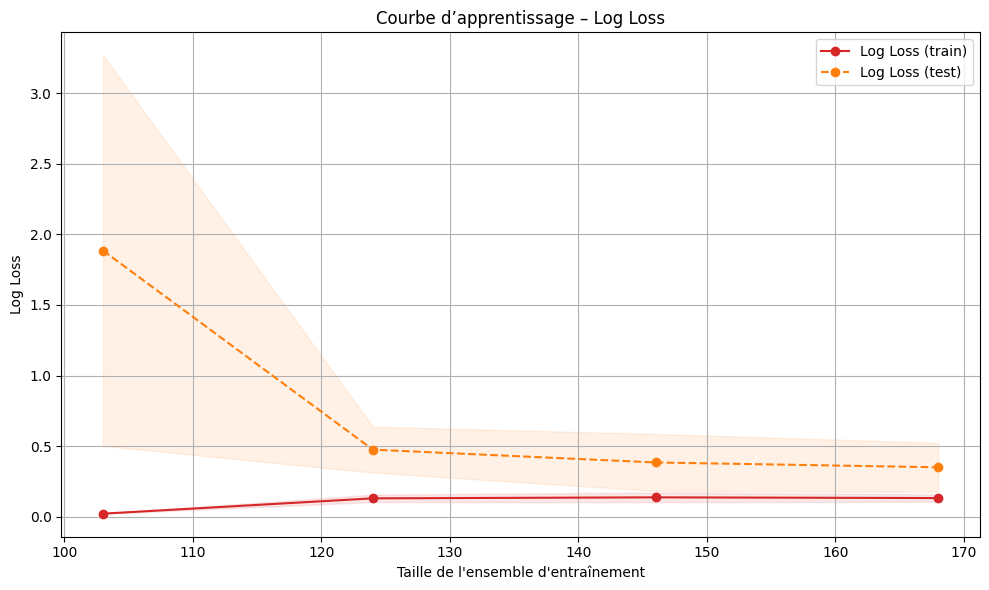

In [105]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Meilleur modèle entraîné (issu du GridSearchCV)
rf_model = grid_search.best_estimator_

# Génération des courbes d'apprentissage (log loss)
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_model,
    X=X_train,
    y=y_train_encoded,
    train_sizes=np.linspace(0.1, 1.0, 8),
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1
)

# Moyennes et écarts-types
train_loss_mean = -np.mean(train_scores, axis=1)
test_loss_mean = -np.mean(test_scores, axis=1)
train_loss_std = np.std(train_scores, axis=1)
test_loss_std = np.std(test_scores, axis=1)

# Affichage
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_loss_mean, 'o-', label='Log Loss (train)', color='tab:red')
plt.plot(train_sizes, test_loss_mean, 'o--', label='Log Loss (test)', color='tab:orange')
plt.fill_between(train_sizes, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.1, color='tab:red')
plt.fill_between(train_sizes, test_loss_mean - test_loss_std, test_loss_mean + test_loss_std, alpha=0.1, color='tab:orange')
plt.title("Courbe d’apprentissage – Log Loss")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Log Loss")
plt.grid(True)
plt.legend(loc="best")
plt.tight_layout()
plt.show()


Text(0, 0.5, 'Score')

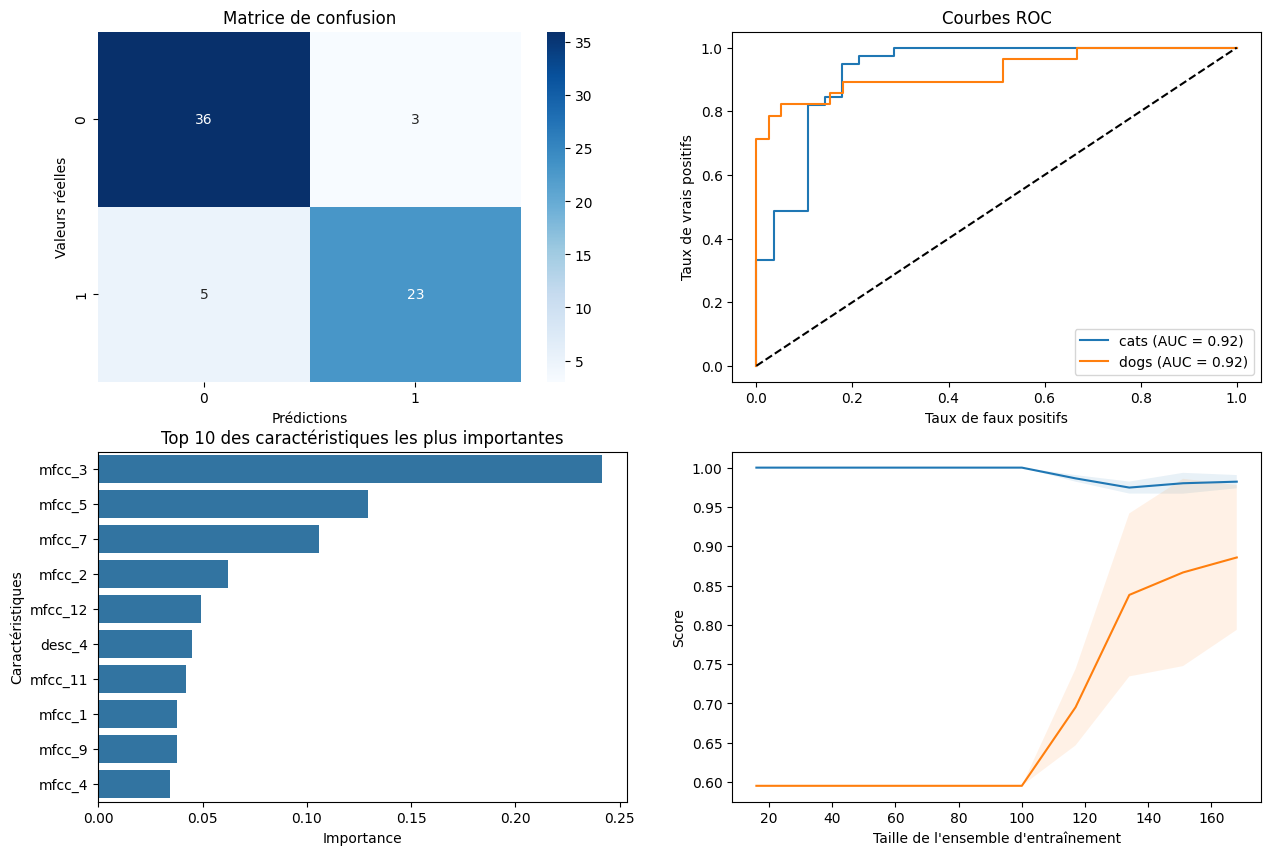

In [106]:
# Création d'une figure avec plusieurs sous-graphiques
plt.figure(figsize=(15, 10))

# 1. Matrice de confusion
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')

# 2. Courbe ROC pour chaque classe
plt.subplot(2, 2, 2)
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_encoded == i, y_pred_proba[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC')
plt.legend()

# 3. Importance des caractéristiques
plt.subplot(2, 2, 3)
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 des caractéristiques les plus importantes')
plt.xlabel('Importance')
plt.ylabel('Caractéristiques')

# 4. Courbe d'apprentissage
plt.subplot(2, 2, 4)
train_sizes, train_scores, test_scores = learning_curve(
    rf_model, X_train, y_train_encoded,
    cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Score d\'entraînement')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Score de validation')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Taille de l\'ensemble d\'entraînement')
plt.ylabel('Score')